In [1]:
# !pip install vaex -q
# !pip install modin[all] -q
# !pip install dask[complete] -q
# !pip install polars -q
# !pip install pandas -q

In [2]:
# !pip install numpy==1.26.4 -q

In [3]:
import os
import re
import sys
import ray
import time
import dask
import vaex
import modin
import pandas
import polars
import psutil
import platform
import subprocess
import warnings
import tracemalloc
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

In [4]:
def get_processor_name():
    if platform.system() == "Windows":
        return platform.processor()
    elif platform.system() == "Darwin":
        os.environ['PATH'] = os.environ['PATH'] + os.pathsep + '/usr/sbin'
        command ="sysctl -n machdep.cpu.brand_string"
        return subprocess.check_output(command).strip()
    elif platform.system() == "Linux":
        command = "cat /proc/cpuinfo"
        all_info = subprocess.check_output(command, shell=True).decode().strip()
        for line in all_info.split("\n"):
            if "model name" in line:
                return re.sub( ".*model name.*:", "", line,1).strip()
    return ""

get_processor_name()

'12th Gen Intel(R) Core(TM) i9-12900K'

In [5]:
cpu_percent = psutil.cpu_percent()
cpu_count = psutil.cpu_count(logical=True)

svmem = psutil.virtual_memory()
total_memory = svmem.total
available_memory = svmem.available
used_memory = svmem.used
memory_percent = svmem.percent

print("CPU Usage:", cpu_percent, "%")
print("Number of CPUs:", cpu_count)
print("Total Memory:", total_memory / (1024 ** 3), "GB")  # Convert to GB
print("Available Memory:", available_memory / (1024 ** 3), "GB")
print("Used Memory:", used_memory / (1024 ** 3), "GB")
print("Memory Usage:", memory_percent, "%")

CPU Usage: 5.2 %
Number of CPUs: 24
Total Memory: 31.08724594116211 GB
Available Memory: 24.653911590576172 GB
Used Memory: 4.9570770263671875 GB
Memory Usage: 20.7 %


In [6]:
print(f"Python Version: {sys.version.split()[0]}")
print(f"Ray Version: {ray.__version__}")
print(f"Modin Version: {modin.__version__}")
print(f"Dask Version: {dask.__version__}")
print(f"Pandas Version: {pandas.__version__}")
print(f"Polars Version: {polars.__version__}")
print(f"Vaex Version: {vaex.__version__}")

Python Version: 3.10.12
Ray Version: 2.39.0
Modin Version: 0.32.0
Dask Version: 2024.11.2
Pandas Version: 2.2.3
Polars Version: 1.14.0
Vaex Version: {'vaex': '4.17.0', 'vaex-core': '4.17.1', 'vaex-viz': '0.5.4', 'vaex-hdf5': '0.14.1', 'vaex-server': '0.9.0', 'vaex-astro': '0.9.3', 'vaex-jupyter': '0.8.2', 'vaex-ml': '0.18.3'}


In [7]:
dataset_path = "../data/archive/sampled_data.csv"
libraries = ['pandas', 'modin', 'polars', 'dask', 'vaex']
library_colors = {
    'pandas': 'blue',
    'modin': 'green',
    'polars': 'orange',
    'dask': 'red',
    'vaex': 'gray'
}

def get_file_size_in_gb(filepath):
    """Gets the size of a file in GB."""
    size_in_bytes = os.path.getsize(filepath)
    size_in_gb = size_in_bytes / (1024 ** 3)
    return size_in_gb

size_in_gb = get_file_size_in_gb(dataset_path)
print(f"The size of {dataset_path} is: {size_in_gb:.2f} GB")

The size of ../data/archive/sampled_data.csv is: 2.11 GB


In [16]:
df = pd.read_csv(dataset_path)
df.shape

(16979506, 9)

In [8]:
import pandas as pd
import polars as pl
import dask.dataframe as dd
import modin.config as modin_cfg

modin_cfg.Engine.put("ray")

import modin.pandas as mpd

def get_current_memory_usage():
    return tracemalloc.get_traced_memory()[0] / (1024 ** 2)  # Current memory in MB

def get_peak_memory_usage():
    return tracemalloc.get_traced_memory()[1] / (1024 ** 2)  # Peak memory in MB

def read_csv_data(library_name, dataset_path, *args, **kwargs):
    if library_name.lower() == 'pandas':
        return pd.read_csv(dataset_path)
    elif library_name.lower() == 'modin':
        return mpd.read_csv(dataset_path)
    elif library_name.lower() == 'polars':
        return pl.read_csv(dataset_path)
    elif library_name.lower() == 'dask':
        return dd.read_csv(dataset_path)
    elif library_name.lower() == 'vaex':
        return vaex.read_csv(dataset_path)
    else:
        raise ValueError("Invalid library name. Must be 'pandas', 'modin', 'polars', 'dask', or 'vaex'")

def find_max_by_brand(library_name, df, **kwargs):
    """
    Find the maximum price by brand.
    """
    if library_name == 'polars':
        return df.group_by('brand').agg(pl.col('price').max().alias('max_price'))
    elif library_name == 'dask':
        return df.groupby('brand')['price'].max().compute()
    elif library_name == 'vaex':
        return df.groupby('brand', agg={'max_price': vaex.agg.max('price')})
    else:
        return df.groupby('brand')['price'].max()

def sort_by_price(library_name, df, **kwargs):
    """
    Sort the DataFrame by price in descending order.
    """
    if library_name == 'polars':
        return df.sort('price', descending=True)
    elif library_name == 'dask':
        return df.sort_values(by='price', ascending=False).compute()
    elif library_name == 'vaex':
        return df.sort(by='price', ascending=False)
    else:
        return df.sort_values(by='price', ascending=False)

def count_null_category_code(library_name, df, **kwargs):
    """
    Count the number of null values in the 'category_code' column.
    """
    if library_name == 'polars':
        return df.filter(pl.col('category_code').is_null()).height
    elif library_name == 'dask':
        return df['category_code'].isnull().sum().compute()
    elif library_name == 'vaex':
        return df.category_code.countna()
    else:
        return df['category_code'].isnull().sum()

def add_brand_null_flag(library_name, df, **kwargs):
    """
    Add a new column 'brand_is_null' that indicates if 'brand' is null.
    """
    if library_name == 'polars':
        df = df.with_columns((pl.col('brand').is_null()).alias('brand_is_null'))
    elif library_name == 'dask':
        df['brand_is_null'] = df['brand'].isnull()
    elif library_name == 'vaex':
        df['brand_is_null'] = df.brand.isna()
    else:
        df['brand_is_null'] = df['brand'].isnull()
    return df

def write_back_to_disk(library_name, df, **kwargs):
    """
    Write the DataFrame back to disk (in CSV format).
    """
    output_path = "../data/archive/" + library_name +  '_output.csv'
    
    if library_name == 'polars':
        df.write_csv(output_path)
    elif library_name == 'dask':
        df.to_csv(output_path, index=False, single_file=True)
    elif library_name == 'vaex':
        df.export_csv(output_path)
    else:
        df.to_csv(output_path, index=False)

In [9]:
def measure_performance(library_name, operation_func, *args, **kwargs):
    tracemalloc.start()
    start_time = time.time()  
    if operation_func.__name__ == "read_csv_data":
        dataset_path = kwargs.get('dataset_path')
        dataframe = operation_func(library_name, dataset_path)
    else:
        df = kwargs.get('df')
        _ = operation_func(library_name, df)
    end_time = time.time() 
    
    execution_time = end_time - start_time
    current_memory, peak_memory = tracemalloc.get_traced_memory()
    tracemalloc.stop() 

    perf_data = {
            "operation": operation_func.__name__,
            "library": library_name,
            "execution_time": execution_time,
            "current_memory": current_memory / (1024 * 1024),  # Convert bytes to MB
            "peak_memory": peak_memory / (1024 * 1024)  # Convert bytes to MB
        }
    if operation_func.__name__ == "read_csv_data":
        return perf_data, dataframe
    else:
        return perf_data, None

def collect_performance_data(library, dataset_path):
    operation_funcs = [
        read_csv_data,
        find_max_by_brand,
        sort_by_price,
        count_null_category_code,
        add_brand_null_flag,
        write_back_to_disk
    ]
    
    performance_data, dataframe = [], None
    for operation_func in operation_funcs:
        if operation_func.__name__ == "read_csv_data":
            perf_data, dataframe = measure_performance(library, dataset_path=dataset_path, operation_func=operation_func, df=dataframe)
        else:
            perf_data, _ = measure_performance(library, dataset_path=dataset_path, operation_func=operation_func, df=dataframe)
        performance_data.append(perf_data)

    del dataframe
    return performance_data


def plot_performance(performance_data):
    operations = ['read_csv_data', 'find_max_by_brand', 'sort_by_price', 'count_null_category_code', 'add_brand_null_flag', 'write_back_to_disk']
    libraries = list(set([entry['library'] for entry in performance_data]))
    
    execution_times = {op: [] for op in operations}
    peak_memory_usage = {op: [] for op in operations}
    
    for library in libraries:
        for entry in performance_data:
            if entry['library'] == library:
                execution_times[entry['operation']].append(entry['execution_time'])
                peak_memory_usage[entry['operation']].append(entry['peak_memory'])
    
    for operation in operations:
        fig, axes = plt.subplots(ncols=2, figsize=(12, 4))
        
        ax = axes[0]
        for i, library in enumerate(libraries):
            bar = ax.bar(library, execution_times[operation][i], color=library_colors[library], alpha=0.7, width=0.4, align='center', edgecolor="black")
            for rect in bar:
                height = rect.get_height()
                ax.text(rect.get_x() + rect.get_width() / 2, height + 0.1, f'{height:.4f}', ha='center', va='bottom', fontsize=10, color='black')
        ax.set_xlabel('Library')
        ax.set_ylabel('Execution Time (seconds)')
        ax.set_title(f'Execution Time for {operation}')
        ax.set_xticks(libraries)
        ax.set_xticklabels(libraries)
        
        ax = axes[1]
        for i, library in enumerate(libraries):
            bar = ax.bar(library, peak_memory_usage[operation][i], color=library_colors[library], alpha=0.7, width=0.4, align='center', edgecolor="black")
            for rect in bar:
                height = rect.get_height()
                ax.text(rect.get_x() + rect.get_width() / 2, height + 0.1, f'{height:.4f}', ha='center', va='bottom', fontsize=10, color='black')
                            
        ax.set_xlabel('Library')
        ax.set_ylabel('Peak Memory Usage (MB)')
        ax.set_title(f'Peak Memory Usage for {operation}')
        ax.set_xticks(libraries)
        ax.set_xticklabels(libraries)

        plt.tight_layout()
        plt.show()

In [10]:
performance_data = []

for library in libraries:
    library_performance = collect_performance_data(library, dataset_path)
    performance_data.extend(library_performance)

2024-11-23 06:18:33,212	INFO worker.py:1819 -- Started a local Ray instance.
(raylet) [2024-11-23 06:20:33,132 E 37596 37596] (raylet) node_manager.cc:3069: 4 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: a8a7d8e5faeb06d13d47e4709c9920e2cd7f30d93441a230fc5f10b2, IP: 192.168.0.21) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 192.168.0.21`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.
(raylet) 
(raylet) [2024-11-23 06:21:33,

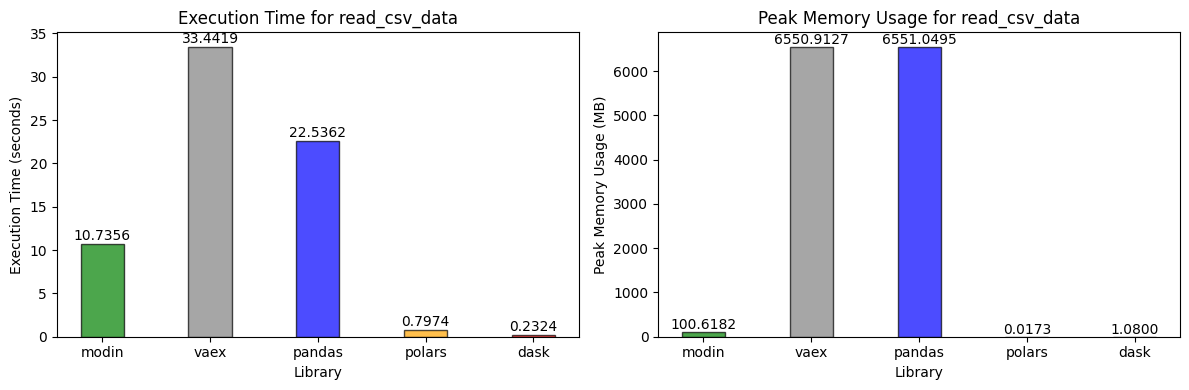

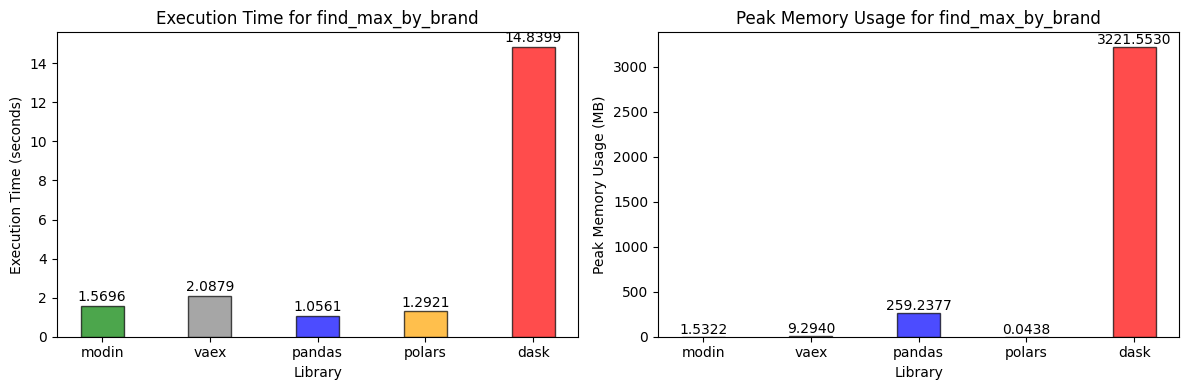

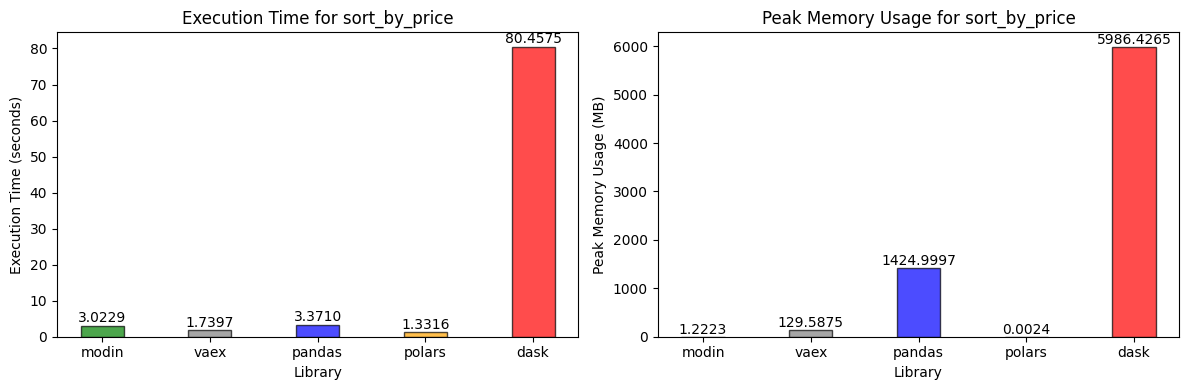

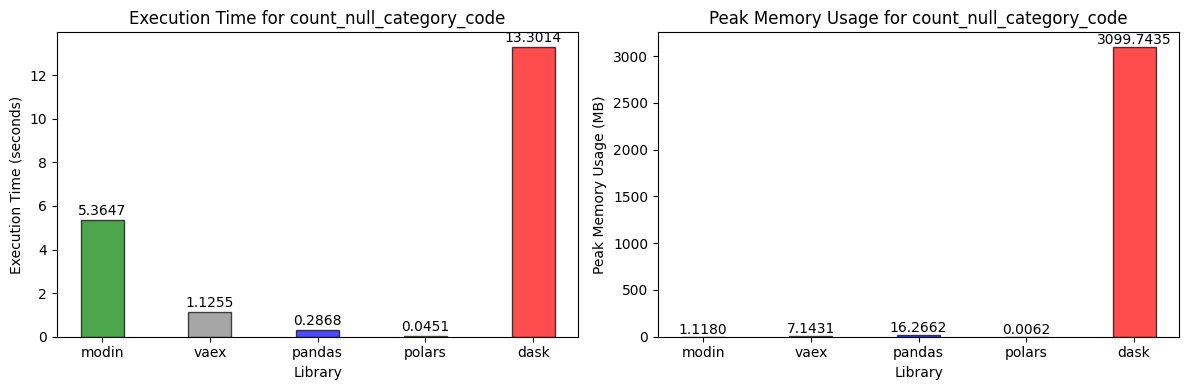

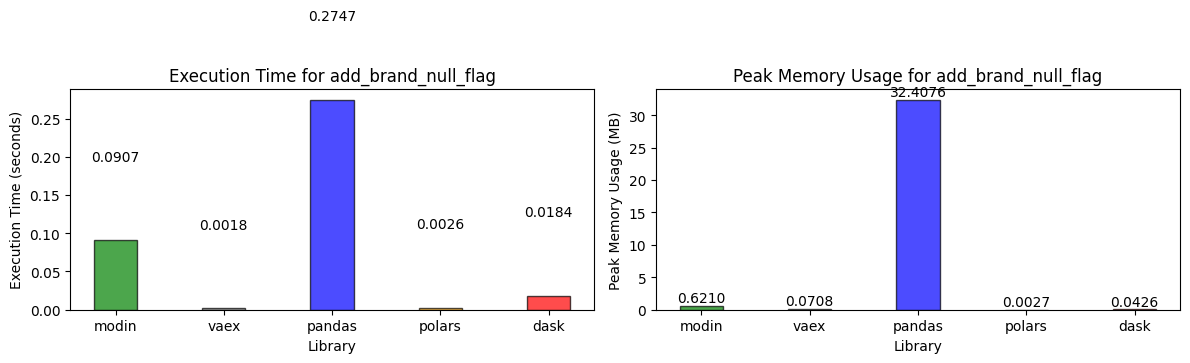

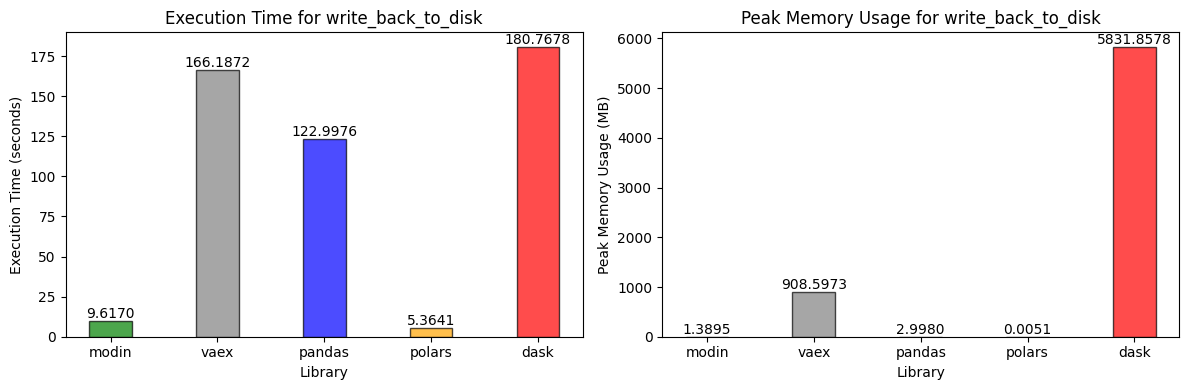

In [11]:
plot_performance(performance_data)

In [12]:
performance_df = pd.DataFrame(performance_data)
operation_dfs = {operation: group.reset_index(drop=True) for operation, group in performance_df.groupby('operation')}

In [13]:
performance_df

,operation,library,execution_time,current_memory,peak_memory
0,read_csv_data,pandas,22.536159,3701.048719,6551.049484
1,find_max_by_brand,pandas,1.056143,0.113836,259.237686
2,sort_by_price,pandas,3.370971,1295.455266,1424.999690
3,count_null_category_code,pandas,0.286840,0.009118,16.266242
4,add_brand_null_flag,pandas,0.274690,16.213713,32.407650
5,write_back_to_disk,pandas,122.997585,0.169217,2.998013
6,read_csv_data,modin,10.735560,13.309019,100.618155
7,find_max_by_brand,modin,1.569627,0.422607,1.532184
8,sort_by_price,modin,3.022866,0.133047,1.222254
9,count_null_category_code,modin,5.364723,0.072375,1.118016


In [14]:
for key in operation_dfs.keys():
    display(operation_dfs[key])

,operation,library,execution_time,current_memory,peak_memory
0,add_brand_null_flag,pandas,0.274690,16.213713,32.407650
1,add_brand_null_flag,modin,0.090747,0.079825,0.621038
2,add_brand_null_flag,polars,0.002646,0.001175,0.002678
3,add_brand_null_flag,dask,0.018386,0.037046,0.042594
4,add_brand_null_flag,vaex,0.001801,0.015450,0.070832


,operation,library,execution_time,current_memory,peak_memory
0,count_null_category_code,pandas,0.286840,0.009118,16.266242
1,count_null_category_code,modin,5.364723,0.072375,1.118016
2,count_null_category_code,polars,0.045073,0.004855,0.006171
3,count_null_category_code,dask,13.301363,0.444411,3099.743539
4,count_null_category_code,vaex,1.125494,0.299712,7.143090


,operation,library,execution_time,current_memory,peak_memory
0,find_max_by_brand,pandas,1.056143,0.113836,259.237686
1,find_max_by_brand,modin,1.569627,0.422607,1.532184
2,find_max_by_brand,polars,1.292060,0.042237,0.043847
3,find_max_by_brand,dask,14.839880,8.934380,3221.553013
4,find_max_by_brand,vaex,2.087926,2.482548,9.293984


,operation,library,execution_time,current_memory,peak_memory
0,read_csv_data,pandas,22.536159,3701.048719,6551.049484
1,read_csv_data,modin,10.735560,13.309019,100.618155
2,read_csv_data,polars,0.797412,0.013700,0.017296
3,read_csv_data,dask,0.232355,0.199008,1.079988
4,read_csv_data,vaex,33.441861,3700.945088,6550.912714


,operation,library,execution_time,current_memory,peak_memory
0,sort_by_price,pandas,3.370971,1295.455266,1424.999690
1,sort_by_price,modin,3.022866,0.133047,1.222254
2,sort_by_price,polars,1.331561,0.001083,0.002388
3,sort_by_price,dask,80.457457,3833.086708,5986.426534
4,sort_by_price,vaex,1.739721,129.585501,129.587504


,operation,library,execution_time,current_memory,peak_memory
0,write_back_to_disk,pandas,122.997585,0.169217,2.998013
1,write_back_to_disk,modin,9.617041,0.103831,1.389472
2,write_back_to_disk,polars,5.364106,0.003701,0.005074
3,write_back_to_disk,dask,180.767823,0.377248,5831.857810
4,write_back_to_disk,vaex,166.187207,6.888586,908.597301
